<a href="https://colab.research.google.com/github/Jangho-Kim-1999/LNN/blob/main/LNN_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade pip

In [ ]:
# pip install jax[tpu] -f https://storage.googleapis.com/jax-releases/libtpu_releases.html

In [ ]:
pip install --upgrade "jax[cpu]"

In [ ]:
pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 53.1 MB/s eta 0:00:00
  Attempting uninstall: jax-cuda12-pjrt
    Found existing installation: jax-cuda12-pjrt 0.4.33
    Uninstalling jax-cuda12-pjrt-0.4.33:
      Successfully uninstalled jax-cuda12-pjrt-0.4.33
  Attempting uninstall: nvidia-cuda-nvcc-cu12
    Found existing installation: nvidia-cuda-nvcc-cu12 12.5.82
    Uninstalling nvidia-cuda-nvcc-cu12-12.5.82:
      Successfully uninstalled nvidia-cuda-nvcc-cu12-12.5.82
  Attempting uninstall: jax-cuda12-plugin
    Found existing installation: jax-cuda12-plugin 0.4.33
    Unins

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
from functools import partial # reduces arguments to function by making some subset implicit

from jax.example_libraries import stax
from jax.example_libraries import optimizers

# visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from moviepy.editor import ImageSequenceClip
from functools import partial
import proglog
from PIL import Image
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

In [ ]:
def f_analytical(state, t=0, m1=1, m2=1, l1=1, l2=1, g=9.8):
  t1, t2, w1, w2 = state
  a1 = (l2 / l1) * (m2 / (m1 + m2)) * jnp.cos(t1 - t2)
  a2 = (l1 / l2) * jnp.cos(t1 - t2)
  f1 = -(l2 / l1) * (m2 / (m1 + m2)) * (w2**2) * jnp.sin(t1 - t2) - \
      (g / l1) * jnp.sin(t1)
  f2 = (l1 / l2) * (w1**2) * jnp.sin(t1 - t2) - (g / l2) * jnp.sin(t2)
  g1 = (f1 - a1 * f2) / (1 - a1 * a2)
  g2 = (f2 - a2 * f1) / (1 - a1 * a2)
  return jnp.stack([w1, w2, g1, g2])

In [ ]:
def lagrangian(q, q_dot, m1, m2, l1, l2, g):
  t1, t2 = q     # theta 1 and theta 2
  w1, w2 = q_dot # omega 1 and omega 2

  # kinetic energy (T)
  T1 = 0.5 * m1 * (l1 * w1)**2
  T2 = 0.5 * m2 * ((l1 * w1)**2 + (l2 * w2)**2 +
                    2 * l1 * l2 * w1 * w2 * jnp.cos(t1 - t2))
  T = T1 + T2

  # potential energy (V)
  y1 = -l1 * jnp.cos(t1)
  y2 = y1 - l2 * jnp.cos(t2)
  V = m1 * g * y1 + m2 * g * y2

  return T - V

def equation_of_motion(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2)
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  return jnp.concatenate([q_t, q_tt])

def solve_lagrangian(lagrangian, initial_state, **kwargs):
  # We currently run odeint on CPUs only, because its cost is dominated by
  # control flow, which is slow on GPUs.
  @partial(jax.jit, backend='cpu')
  def f(initial_state):
    return odeint(partial(equation_of_motion, lagrangian),
                  initial_state, **kwargs)
  return f(initial_state)


In [ ]:
# Double pendulum dynamics via the rewritten Euler-Lagrange
@partial(jax.jit, backend='cpu')
def solve_autograd(initial_state, times, m1=1, m2=1, l1=1, l2=1, g=9.8):
  L = partial(lagrangian, m1=m1, m2=m2, l1=l1, l2=l2, g=g)
  return solve_lagrangian(L, initial_state, t=times, rtol=1e-10, atol=1e-10)

# Double pendulum dynamics via analytical forces taken from Diego's blog
@partial(jax.jit, backend='cpu')
def solve_analytical(initial_state, times):
  return odeint(f_analytical, initial_state, t=times, rtol=1e-10, atol=1e-10)

def normalize_dp(state):
  # wrap generalized coordinates to [-pi, pi]
  return jnp.concatenate([(state[:2] + np.pi) % (2 * np.pi) - np.pi, state[2:]])

def rk4_step(f, x, t, h):
  # one step of runge-kutta integration
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [ ]:
# LNN 모델
def learned_lagrangian(params):
  def lagrangian(q, q_t):
    assert q.shape == (2,)
    state = normalize_dp(jnp.concatenate([q, q_t]))
    return jnp.squeeze(nn_forward_fn(params, state), axis=-1)
  return lagrangian

# define the loss of the model (MSE between predicted q, \dot q and targets)
@jax.jit
def loss(params, batch, time_step=None):
  state, targets = batch #targets: x_train, xt_train = ((q, qdot)(qdot, qddot))
  if time_step is not None:
    f = partial(equation_of_motion, learned_lagrangian(params))
    preds = jax.vmap(partial(rk4_step, f, t=0.0, h=time_step))(state)
  else:
    preds = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(state)
  return jnp.mean((preds - targets) ** 2)

# build a neural network model
init_random_params, nn_forward_fn = stax.serial(
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(1),
)

In [ ]:
# 학습 데이터 수집
time_step = 0.01
N = 2000

# # x0 = np.array([-0.3*np.pi, 0.2*np.pi, 0.35*np.pi, 0.5*np.pi], dtype=np.float32)
# x0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
# t = np.arange(N, dtype=np.float32) # time steps 0 to N
# %time x_train = jax.device_get(solve_analytical(x0, t)) # dynamics for first N time steps
# %time xt_train = jax.device_get(jax.vmap(f_analytical)(x_train)) # time derivatives of each state

# noise = np.random.RandomState(0).randn(x0.size)
# t_test = np.arange(N, 2*N, dtype=np.float32) # time steps N to 2N
# %time x_test = jax.device_get(solve_analytical(x0, t_test)) # dynamics for next N time steps
# %time xt_test = jax.device_get(jax.vmap(f_analytical)(x_test)) # time derivatives of each state


num_initial_conditions = 10  # Number of different initial conditions

# Generate multiple initial conditions
initial_conditions = np.random.uniform(low=[0, 0, 0, 0], high=[2*np.pi, 2*np.pi, 0, 0],
                                        size=(num_initial_conditions, 4)).astype(np.float32)

# Storage for multiple initial conditions
x_train_list, xt_train_list, y_train_list = [], [], []
x_test_list, xt_test_list, y_test_list = [], [], []

for x0 in initial_conditions:
    t = np.arange(N, dtype=np.float32)  # time steps 0 to N
    x_train = jax.device_get(solve_analytical(x0, t))
    xt_train = jax.device_get(jax.vmap(f_analytical)(x_train))

    t_test = np.arange(N, 2*N, dtype=np.float32)  # time steps N to 2N
    x_test = jax.device_get(solve_analytical(x0, t_test))
    xt_test = jax.device_get(jax.vmap(f_analytical)(x_test))

    # Append data
    x_train_list.append(x_train)
    xt_train_list.append(xt_train)

    x_test_list.append(x_test)
    xt_test_list.append(xt_test)
    print(x0)

# Stack all data to create a larger dataset
x_train = np.vstack(x_train_list)
xt_train = np.vstack(xt_train_list)

x_test = np.vstack(x_test_list)
xt_test = np.vstack(xt_test_list)

# Display shapes to verify
print("x_train shape:", x_train.shape)
print("xt_train shape:", xt_train.shape)
print("x_test shape:", x_test.shape)
print("xt_test shape:", xt_test.shape)

[3.0759137 5.2884445 0.        0.       ]
[0.6386147 3.470317  0.        0.       ]
[3.4039216 3.5253024 0.        0.       ]
[1.4295216 6.134961  0.        0.       ]
[0.3599859  0.15315303 0.         0.        ]
[3.0715337 5.414564  0.        0.       ]
[4.4307814  0.10307415 0.         0.        ]
[1.7751571 0.2212081 0.        0.       ]
[5.567407 2.994959 0.       0.      ]
[0.2486168 5.1678286 0.        0.       ]
x_train shape: (20000, 4)
xt_train shape: (20000, 4)
x_test shape: (20000, 4)
xt_test shape: (20000, 4)


In [ ]:
from google.colab import files
import os

train_np = jax.tree_util.tree_map(lambda x: np.array(x), (x_train, xt_train))
test_np = jax.tree_util.tree_map(lambda x: np.array(x), (x_test, xt_test))

# Save with explicit names instead of using "train_0", "train_1"
np.savez("Trains_20000.npz", x_train=train_np[0], xt_train=train_np[1])
np.savez("Tests_20000.npz", x_test=test_np[0], xt_test=test_np[1])

# Download saved files
files.download("Trains_20000.npz")
files.download("Tests_20000.npz")

print("Train, test sets saved and downloaded!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Train, test sets saved and downloaded!


In [ ]:
#Download & Upload 학습 데이터
from google.colab import files
import os
# Upload files
uploaded = files.upload()

# Load Train and Test Data
trains_loaded = np.load("Trains_5000.npz")
tests_loaded = np.load("Tests_5000.npz")

# Verify keys in the saved files
print("Train Set Keys:", trains_loaded.files)
print("Test Set Keys:", tests_loaded.files)

# Convert NumPy arrays back to JAX
x_train = jnp.array(trains_loaded["x_train"])
xt_train = jnp.array(trains_loaded["xt_train"])

x_test = jnp.array(tests_loaded["x_test"])
xt_test = jnp.array(tests_loaded["xt_test"])

print("Train and test sets successfully loaded as JAX arrays!")
print("Train Shapes:", x_train.shape, xt_train.shape, y_train.shape)
print("Test Shapes:", x_test.shape, xt_test.shape)

Saving Tests_20000.npz to Tests_20000.npz
Saving Trains_20000.npz to Trains_20000.npz
Train Set Keys: ['x_train', 'xt_train']
Test Set Keys: ['x_test', 'xt_test']


KeyError: 'y_train is not a file in the archive'

In [ ]:
time_step = 0.01
N = 20000

@jax.jit
def update_timestep(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, time_step), opt_state)

@jax.jit
def update_derivative(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, None), opt_state)

x_train = jax.device_put(jax.vmap(normalize_dp)(x_train))
x_test = jax.device_put(jax.vmap(normalize_dp)(x_test))


In [ ]:
%%time

rng = jax.random.PRNGKey(0)
_, init_params = init_random_params(rng, (-1, 4))

# numbers in comments denote stephan's settings
batch_size = 100
test_every = 10
num_batches = 20000

train_losses = []
test_losses = []

# adam w learn rate decay
opt_init, opt_update, get_params = optimizers.adam(
    lambda t: jnp.select([t < batch_size*(num_batches//3),
                          t < batch_size*(2*num_batches//3),
                          t > batch_size*(2*num_batches//3)],
                         [1e-3, 3e-4, 1e-4]))
opt_state = opt_init(init_params)

for iteration in range(num_batches*batch_size + 1):
  if iteration % batch_size == 0:
    params = get_params(opt_state)
    train_loss = loss(params, (x_train, xt_train))
    train_losses.append(train_loss)
    test_loss = loss(params, (x_test, xt_test))
    test_losses.append(test_loss)
    if iteration % (batch_size*test_every) == 0:
      print(f"iteration={iteration}, train_loss={train_loss:.6f}, test_loss={test_loss:.6f}")
  opt_state = update_derivative(iteration, opt_state, (x_train, xt_train))

params_LNN_20000_2000000 = get_params(opt_state)

iteration=0, train_loss=76.875275, test_loss=76.870499
iteration=1000, train_loss=26.677010, test_loss=26.675817
iteration=2000, train_loss=8.615250, test_loss=8.623919
iteration=3000, train_loss=4.549851, test_loss=4.546830
iteration=4000, train_loss=1.868971, test_loss=1.867755
iteration=5000, train_loss=0.385769, test_loss=0.387053
iteration=6000, train_loss=0.250164, test_loss=0.250393
iteration=7000, train_loss=0.210217, test_loss=0.210403
iteration=8000, train_loss=0.193964, test_loss=0.194138
iteration=9000, train_loss=0.188260, test_loss=0.188390
iteration=10000, train_loss=0.178855, test_loss=0.179021
iteration=11000, train_loss=0.173699, test_loss=0.173894
iteration=12000, train_loss=0.165548, test_loss=0.165698
iteration=13000, train_loss=0.161810, test_loss=0.161964
iteration=14000, train_loss=0.156157, test_loss=0.156326
iteration=15000, train_loss=0.154015, test_loss=0.154214


In [ ]:
from google.colab import files
import os

In [ ]:
# Convert JAX parameters to NumPy format
params_np_NN = jax.tree_util.tree_map(np.array, params_LNN_20000_2000000)

# Flatten the JAX parameter tree
params_flat, tree_def = jax.tree_util.tree_flatten(params_np_NN)

# Save each parameter separately
params_dict_NN = {f"param_{i}": param for i, param in enumerate(params_flat)}

# Also save the tree structure (needed for restoring)
params_dict_NN["tree_def"] = tree_def

# Save to a file
np.savez("params_LNN_20000_2000000.npz", **params_dict_NN)

# Download the file
files.download("params_LNN_20000_2000000.npz")

print("✅ Parameters saved successfully as params_LNN_20000_2000000.npz")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Parameters saved successfully as params_LNN_2000_131000.npz


In [ ]:
######## only NN #########
def learned_NN(params_NN):
  def output_NN(q, q_t):
    assert q.shape == (2,)
    state = normalize_dp(jnp.concatenate([q, q_t]))
    q_tt = nn_forward_fn_NN(params_NN, state)
    return q_tt
  return output_NN

# define the loss of the model (MSE between predicted q, \dot q and targets)
@jax.jit
def loss_NN(params, batch, time_step=None):
  state, targets = batch  #state = (q, qdot) targets = (qdot, qddot)
  targets = targets[:,2:]

  preds_fn = learned_NN(params)  # This is a function
  preds = jax.vmap(preds_fn)(state[:, :2], state[:, 2:])  # Compute predictions

  return jnp.mean((preds - targets) ** 2)

# build a neural network model
init_random_params_NN, nn_forward_fn_NN = stax.serial(
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(2),
)

In [ ]:
@jax.jit
def update_timestep_NN(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss_NN)(params, batch, time_step), opt_state)

@jax.jit
def update_derivative_NN(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss_NN)(params, batch, None), opt_state)

# x_train = jax.device_put(jax.vmap(normalize_dp)(x_train))
# xt_train = jax.device_put(jax.vmap(normalize_dp)(xt_train))
# y_train = jax.device_put(y_train)

# x_test = jax.device_put(jax.vmap(normalize_dp)(x_test))
# xt_test = jax.device_put(jax.vmap(normalize_dp)(xt_test))
# y_test = jax.device_put(y_test)

In [ ]:
%%time

rng = jax.random.PRNGKey(0)
_, init_params_NN = init_random_params_NN(rng, (-1, 4))

# numbers in comments denote stephan's settings
batch_size = 100
test_every = 10
num_batches = 1500

train_losses_NN = []
test_losses_NN = []

# adam w learn rate decay
opt_init, opt_update, get_params = optimizers.adam(
    lambda t: jnp.select([t < batch_size*(num_batches//3),
                          t < batch_size*(2*num_batches//3),
                          t > batch_size*(2*num_batches//3)],
                         [1e-3, 3e-4, 1e-4]))
opt_state = opt_init(init_params_NN)

for iteration in range(150001):
  if iteration % batch_size == 0:
    params = get_params(opt_state)

    train_loss_NN = loss_NN(params, (x_train, xt_train))
    train_losses_NN.append(train_loss_NN)
    test_loss_NN = loss_NN(params, (x_test, xt_test))
    test_losses_NN.append(test_loss_NN)


    if iteration % (batch_size*test_every) == 0:
      print(f"iteration={iteration}, train_loss={train_loss_NN:.6f}, test_loss={test_loss_NN:.6f}")
  opt_state = update_derivative_NN(iteration, opt_state, (x_train, xt_train))

params_NN = get_params(opt_state)

iteration=0, train_loss=313.442413, test_loss=321.995331
iteration=1000, train_loss=4.663168, test_loss=6.888652
iteration=2000, train_loss=1.882852, test_loss=3.128171
iteration=3000, train_loss=0.951845, test_loss=1.796091
iteration=4000, train_loss=0.639031, test_loss=1.340246
iteration=5000, train_loss=0.466982, test_loss=1.091731
iteration=6000, train_loss=0.362615, test_loss=0.917221
iteration=7000, train_loss=0.301881, test_loss=0.815417
iteration=8000, train_loss=0.249579, test_loss=0.788939
iteration=9000, train_loss=0.215202, test_loss=0.759177
iteration=10000, train_loss=0.188486, test_loss=0.731833
iteration=11000, train_loss=0.167149, test_loss=0.708002
iteration=12000, train_loss=0.149916, test_loss=0.700782
iteration=13000, train_loss=0.149214, test_loss=0.721743
iteration=14000, train_loss=0.122839, test_loss=0.674084
iteration=15000, train_loss=0.112736, test_loss=0.668104
iteration=16000, train_loss=0.105384, test_loss=0.670534
iteration=17000, train_loss=0.097052, te

In [ ]:
# Convert JAX parameters to NumPy format
params_np_NN = jax.tree_util.tree_map(np.array, params_NN)

# Flatten the JAX parameter tree
params_flat, tree_def = jax.tree_util.tree_flatten(params_np_NN)

# Save each parameter separately
params_dict_NN = {f"param_{i}": param for i, param in enumerate(params_flat)}

# Also save the tree structure (needed for restoring)
params_dict_NN["tree_def"] = tree_def

# Save to a file
np.savez("params_NN.npz", **params_dict_NN)

# Download the file
files.download("params_NN.npz")

print("✅ Parameters saved successfully as params_NN.npz")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Parameters saved successfully as params_NN.npz


In [ ]:
# Upload file
uploaded = files.upload()

# Load parameters from the npz file
params_loaded = np.load("params_LNN_2000_131000.npz", allow_pickle=True)

# Print available parameter keys for debugging
print("Keys in saved parameters:", params_loaded.files)

# Restore the tree structure
tree_def = params_loaded["tree_def"].item()  # Extract tree structure

# Restore individual parameters
params_flat = [params_loaded[f"param_{i}"] for i in range(len(params_loaded.files) - 1)]  # Exclude "tree_def"

# Convert back to JAX format
params_LNN_2000_131000 = jax.tree_util.tree_unflatten(tree_def, params_flat)

print("✅ Params successfully loaded as JAX arrays!")

# Example: Print the shape of each parameter
for i, param in enumerate(jax.tree_util.tree_leaves(params_LNN_2000_131000)):
    print(f"Parameter {i} shape: {param.shape}")


Saving params_LNN_2000_131000.npz to params_LNN_2000_131000.npz
Keys in saved parameters: ['param_0', 'param_1', 'param_2', 'param_3', 'param_4', 'param_5', 'tree_def']
✅ Params successfully loaded as JAX arrays!
Parameter 0 shape: (4, 128)
Parameter 1 shape: (128,)
Parameter 2 shape: (128, 128)
Parameter 3 shape: (128,)
Parameter 4 shape: (128, 1)
Parameter 5 shape: (1,)


In [ ]:
# Upload file
uploaded = files.upload()

# Load parameters from the npz file
params_loaded = np.load("params_NN_2000_4000000.npz", allow_pickle=True)

# Print available parameter keys for debugging
print("Keys in saved parameters:", params_loaded.files)

# Restore the tree structure
tree_def = params_loaded["tree_def"].item()  # Extract tree structure

# Restore individual parameters
params_flat = [params_loaded[f"param_{i}"] for i in range(len(params_loaded.files) - 1)]  # Exclude "tree_def"

# Convert back to JAX format
params_NN_2000_4000000 = jax.tree_util.tree_unflatten(tree_def, params_flat)

print("✅ Params successfully loaded as JAX arrays!")

# Example: Print the shape of each parameter
for i, param in enumerate(jax.tree_util.tree_leaves(params_NN_2000_4000000)):
    print(f"Parameter {i} shape: {param.shape}")


Saving params_NN_2000_4000000.npz to params_NN_2000_4000000.npz
Keys in saved parameters: ['param_0', 'param_1', 'param_2', 'param_3', 'param_4', 'param_5', 'tree_def']
✅ Params successfully loaded as JAX arrays!
Parameter 0 shape: (4, 128)
Parameter 1 shape: (128,)
Parameter 2 shape: (128, 128)
Parameter 3 shape: (128,)
Parameter 4 shape: (128, 2)
Parameter 5 shape: (2,)


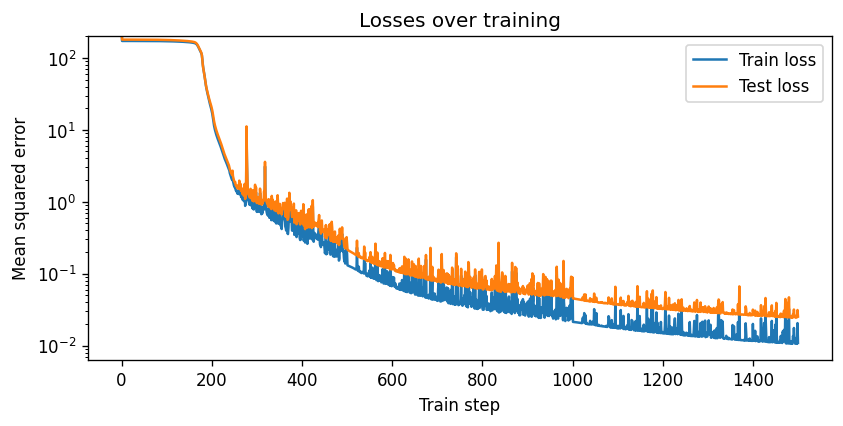

In [ ]:
plt.figure(figsize=(8, 3.5), dpi=120)
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.yscale('log')
plt.ylim(None, 200)
plt.title('Losses over training')
plt.xlabel("Train step") ; plt.ylabel("Mean squared error")
plt.legend() ; plt.show()

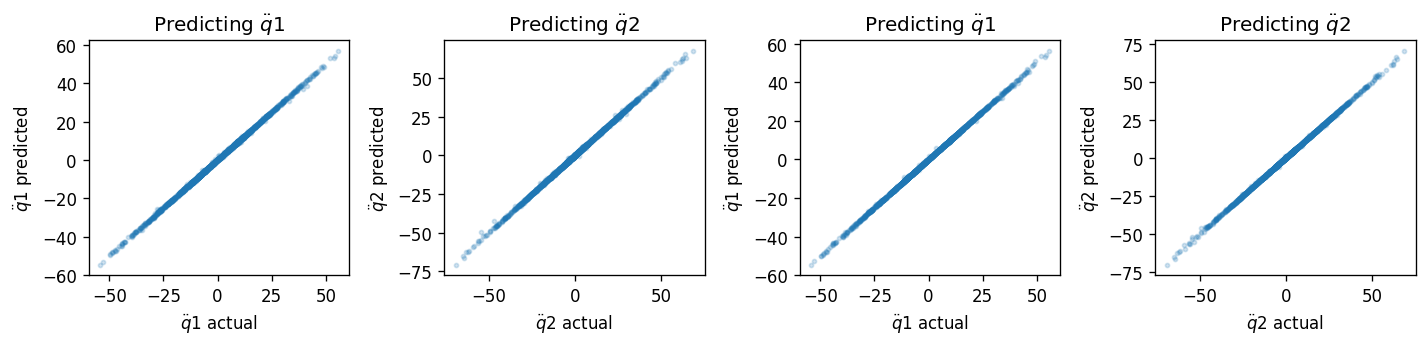

In [ ]:
# lagrangian_fn = learned_lagrangian(params_LNN)  # Ensure this is correctly returned
# xt_pred_LNN = jax.vmap(lambda state: equation_of_motion(lagrangian_fn, state))(x_test)

xt_pred_LNN = jax.vmap(partial(equation_of_motion, learned_lagrangian(params_LNN_2000_131000)))(x_test)
preds_fn = learned_NN(params_NN_2000_4000000)  # This is a function
xt_pred_NN = jax.vmap(preds_fn)(x_test[:, :2],x_test[:, 2:])  # Compute predictions

fig, axes = plt.subplots(1, 4, figsize=(12, 3), dpi=120)

axes[0].scatter(xt_test[:, 2], xt_pred_LNN[:, 2], s=6, alpha=0.2)
axes[0].set_title('Predicting $\ddot q1$')
axes[0].set_xlabel('$\ddot q1$ actual')
axes[0].set_ylabel('$\ddot q1$ predicted')
axes[1].scatter(xt_test[:, 3], xt_pred_LNN[:, 3], s=6, alpha=0.2)
axes[1].set_title('Predicting $\ddot q2$')
axes[1].set_xlabel('$\ddot q2$ actual')
axes[1].set_ylabel('$\ddot q2$ predicted')

axes[2].scatter(xt_test[:, 2], xt_pred_NN[:, 0], s=6, alpha=0.2)
axes[2].set_title('Predicting $\ddot q1$')
axes[2].set_xlabel('$\ddot q1$ actual')
axes[2].set_ylabel('$\ddot q1$ predicted')
axes[3].scatter(xt_test[:, 3], xt_pred_NN[:, 1], s=6, alpha=0.2)
axes[3].set_title('Predicting $\ddot q2$')
axes[3].set_xlabel('$\ddot q2$ actual')
axes[3].set_ylabel('$\ddot q2$ predicted')

plt.tight_layout()

In [ ]:
def f_NN(state, t):
  q, q_t = jnp.split(state, 2)
  preds_fn = learned_NN(params_NN_2000_4000000)  # This is a function
  print(q.shape)
  print(q_t.shape)
  xt_pred_NN = preds_fn(q, q_t)  # Compute predictions

  q_tt = xt_pred_NN  # NN predicts accelerations
  return jnp.concatenate([q_t, q_tt])  # [theta_dot1, theta_dot2, theta_ddot1, theta_ddot2]

def solve_NN(initial_state, times):
  return odeint(f_NN, initial_state, times)


CPU times: user 1.03 s, sys: 24.4 ms, total: 1.06 s
Wall time: 1.1 s
CPU times: user 3.45 s, sys: 128 ms, total: 3.58 s
Wall time: 2.89 s
(2,)
(2,)
CPU times: user 1.12 s, sys: 20.9 ms, total: 1.14 s
Wall time: 811 ms


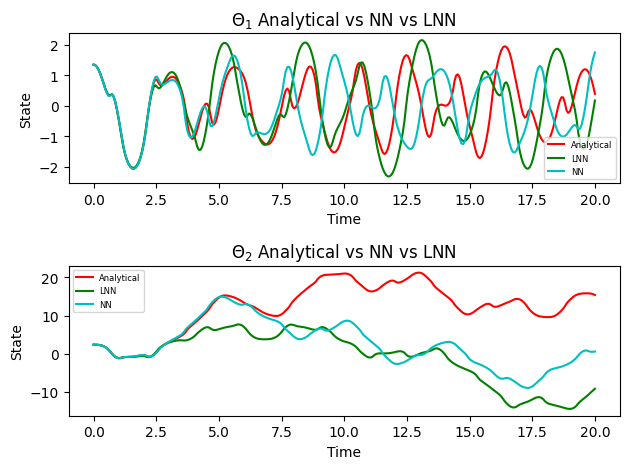

In [ ]:
#시간에 대한 함수로 나타내자.
# choose an initial state
x1 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
t2 = np.linspace(0, 20, num=301)

%time Analytical_model = jax.device_get(solve_analytical(x1, t2))
%time LNN_model = jax.device_get(solve_lagrangian(learned_lagrangian(params_LNN_2000_131000), x1, t=t2))

#NN 시간에 대한 함수로 나타내야함
%time NN_model = jax.device_get(solve_NN(x1,t2))

# plt.figure(figsize=[10,6], dpi=120) ; plt.xlim(0, 20)
plt.subplot(2,1,1)
plt.title("$\Theta_1$ Analytical vs NN vs LNN")
plt.xlabel("Time") ; plt.ylabel("State")
plt.plot(t2, Analytical_model[:, 0], 'r-', label=r'Analytical')
plt.plot(t2, LNN_model[:, 0], 'g-', label=r'LNN')
plt.plot(t2, NN_model[:, 0], 'c-', label=r'NN')

plt.legend(fontsize=6)


plt.subplot(2,1,2)
plt.title("$\Theta_2$ Analytical vs NN vs LNN")
plt.xlabel("Time") ; plt.ylabel("State")
plt.plot(t2, Analytical_model[:, 1], 'r-', label=r'Analytical')
plt.plot(t2, LNN_model[:, 1], 'g-', label=r'LNN')
plt.plot(t2, NN_model[:, 1], 'c-', label=r'NN')

plt.legend(fontsize=6)

plt.tight_layout() ; plt.show()

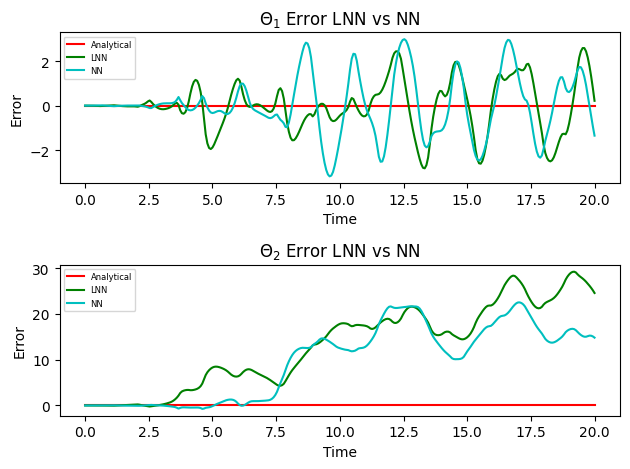

In [ ]:
#성능평가 Error 비교

# plt.figure(figsize=[10,6], dpi=120) ; plt.xlim(0, 20)

# mse_LNN_theta1 = jnp.su

plt.subplot(2,1,1)
plt.title("$\Theta_1$ Error LNN vs NN")
plt.xlabel("Time") ; plt.ylabel("Error")
plt.plot(t2, Analytical_model[:, 0]-Analytical_model[:, 0], 'r-', label=r'Analytical')
plt.plot(t2, Analytical_model[:, 0]-LNN_model[:, 0], 'g-', label=r'LNN')
plt.plot(t2, Analytical_model[:, 0]-NN_model[:, 0], 'c-', label=r'NN')
plt.legend(fontsize=6)

plt.subplot(2,1,2)
plt.title("$\Theta_2$ Error LNN vs NN")
plt.xlabel("Time") ; plt.ylabel("Error")
plt.plot(t2, Analytical_model[:, 1]-Analytical_model[:, 1], 'r-', label=r'Analytical')
plt.plot(t2, Analytical_model[:, 1]-LNN_model[:, 1], 'g-', label=r'LNN')
plt.plot(t2, Analytical_model[:, 1]-NN_model[:, 1], 'c-', label=r'NN')
plt.legend(fontsize=6)

plt.tight_layout() ; plt.show()

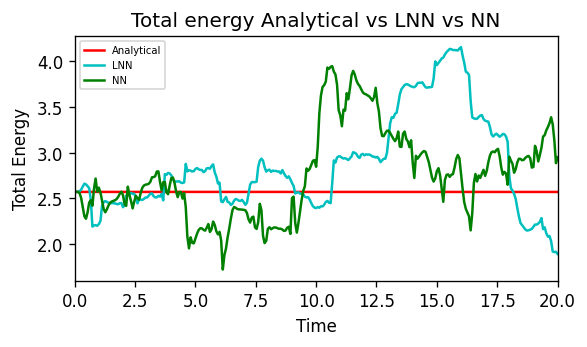

In [ ]:
#성능평가 Total Energy 비교
def tot_energy(state, m1, m2, l1, l2, g):
  t1, t2, w1, w2 = jnp.split(state, 4, axis = 1)
  # t1, t2 = q     # theta 1 and theta 2
  # w1, w2 = q_dot # omega 1 and omega 2

  # kinetic energy (T)
  T1 = 0.5 * m1 * (l1 * w1)**2
  T2 = 0.5 * m2 * ((l1 * w1)**2 + (l2 * w2)**2 +
                    2 * l1 * l2 * w1 * w2 * jnp.cos(t1 - t2))
  T = T1 + T2

  # potential energy (V)
  y1 = -l1 * jnp.cos(t1)
  y2 = y1 - l2 * jnp.cos(t2)
  V = m1 * g * y1 + m2 * g * y2
  return T + V

Analy_tot_energy = jnp.squeeze(tot_energy(Analytical_model, m1=1, m2=1, l1=1, l2=1, g=9.8), axis=1)
NN_tot_energy = jnp.squeeze(tot_energy(LNN_model, m1=1, m2=1, l1=1, l2=1, g=9.8), axis=1)
LNN_tot_energy = jnp.squeeze(tot_energy(NN_model, m1=1, m2=1, l1=1, l2=1, g=9.8), axis=1)


plt.figure(figsize=[5,3], dpi=120) ; plt.xlim(0, 20)

plt.title("Total energy Analytical vs LNN vs NN")
plt.xlabel("Time") ; plt.ylabel("Total Energy")
plt.plot(t2, Analy_tot_energy, 'r-', label=r'Analytical')
plt.plot(t2, LNN_tot_energy, 'c-', label=r'LNN')
plt.plot(t2, NN_tot_energy, 'g-', label=r'NN')

plt.legend(fontsize=6)

plt.tight_layout() ; plt.show()

CPU times: user 4.61 ms, sys: 0 ns, total: 4.61 ms
Wall time: 4.63 ms


NameError: name 'params_LNN' is not defined

CPU times: user 59.7 ms, sys: 0 ns, total: 59.7 ms
Wall time: 60.5 ms
CPU times: user 9.87 ms, sys: 0 ns, total: 9.87 ms
Wall time: 9.88 ms


NameError: name 'params_LNN' is not defined

CPU times: user 104 ms, sys: 0 ns, total: 104 ms
Wall time: 104 ms
CPU times: user 5.01 ms, sys: 0 ns, total: 5.01 ms
Wall time: 5.02 ms


NameError: name 'params_LNN' is not defined

CPU times: user 58.4 ms, sys: 0 ns, total: 58.4 ms
Wall time: 58.7 ms
CPU times: user 88 ms, sys: 0 ns, total: 88 ms
Wall time: 87.9 ms


NameError: name 'params_LNN' is not defined

CPU times: user 174 ms, sys: 0 ns, total: 174 ms
Wall time: 174 ms
CPU times: user 79.7 ms, sys: 0 ns, total: 79.7 ms
Wall time: 77.6 ms


NameError: name 'params_LNN' is not defined

CPU times: user 3.48 s, sys: 1.26 ms, total: 3.48 s
Wall time: 3.52 s
CPU times: user 68.9 ms, sys: 0 ns, total: 68.9 ms
Wall time: 69.9 ms


NameError: name 'params_LNN' is not defined

CPU times: user 153 ms, sys: 0 ns, total: 153 ms
Wall time: 158 ms
CPU times: user 19.5 ms, sys: 0 ns, total: 19.5 ms
Wall time: 19.8 ms


NameError: name 'params_LNN' is not defined

CPU times: user 127 ms, sys: 0 ns, total: 127 ms
Wall time: 135 ms
CPU times: user 12.5 ms, sys: 0 ns, total: 12.5 ms
Wall time: 12.4 ms


NameError: name 'params_LNN' is not defined

CPU times: user 88.7 ms, sys: 0 ns, total: 88.7 ms
Wall time: 103 ms
CPU times: user 85 ms, sys: 0 ns, total: 85 ms
Wall time: 88.5 ms


NameError: name 'params_LNN' is not defined

CPU times: user 176 ms, sys: 0 ns, total: 176 ms
Wall time: 181 ms
CPU times: user 112 ms, sys: 0 ns, total: 112 ms
Wall time: 113 ms


NameError: name 'params_LNN' is not defined

CPU times: user 206 ms, sys: 0 ns, total: 206 ms
Wall time: 205 ms


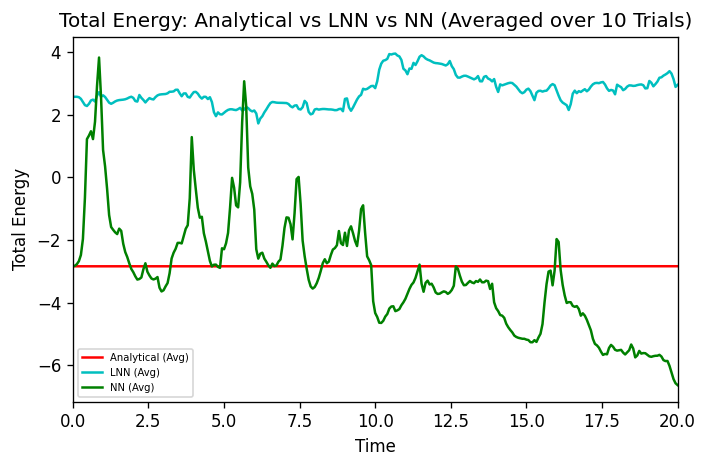

In [ ]:
# Simulation parameters
num_trials = 10  # Number of random initial conditions
t2 = np.linspace(0, 20, num=301)  # Time array

# Function to generate random initial conditions
def generate_random_initial_conditions():
    theta1 = np.random.uniform(0, np.pi)  # Random theta1
    theta2 = np.random.uniform(0, np.pi)  # Random theta2
    omega1 = 0 #np.random.uniform(-1, 1)  # Small initial velocity
    omega2 = 0 # np.random.uniform(-1, 1)
    return np.array([theta1, theta2, omega1, omega2], dtype=np.float32)


# Initialize arrays for storing total energy for all trials
Analy_tot_energies = []
NN_tot_energies = []
LNN_tot_energies = []

# Run the simulations for multiple random initial conditions
for _ in range(num_trials):
    x1 = generate_random_initial_conditions()

    # Compute the solutions
    %time Analytical_model = jax.device_get(solve_analytical(x1, t2))
    %time LNN_model = jax.device_get(solve_lagrangian(learned_lagrangian(params_LNN), x1, t=t2))
    %time NN_model = jax.device_get(solve_NN(x1, t2))

    # Compute total energy for each trial
    Analy_tot_energies.append(jnp.squeeze(tot_energy(Analytical_model, m1=1, m2=1, l1=1, l2=1, g=9.8), axis=1))
    LNN_tot_energies.append(jnp.squeeze(tot_energy(LNN_model, m1=1, m2=1, l1=1, l2=1, g=9.8), axis=1))
    NN_tot_energies.append(jnp.squeeze(tot_energy(NN_model, m1=1, m2=1, l1=1, l2=1, g=9.8), axis=1))

# Convert lists to arrays for easy averaging
Analy_tot_energies = np.array(Analy_tot_energies)  # Shape: (num_trials, num_timesteps)
LNN_tot_energies = np.array(LNN_tot_energies)
NN_tot_energies = np.array(NN_tot_energies)

# Compute the mean total energy for each time step
Analy_tot_energy_avg = np.mean(Analy_tot_energies, axis=0)
LNN_tot_energy_avg = np.mean(LNN_tot_energies, axis=0)
NN_tot_energy_avg = np.mean(NN_tot_energies, axis=0)

# Plot results
plt.figure(figsize=[6, 4], dpi=120)
plt.xlim(0, 20)

plt.title("Total Energy: Analytical vs LNN vs NN (Averaged over 10 Trials)")
plt.xlabel("Time")
plt.ylabel("Total Energy")

plt.plot(t2, Analy_tot_energy_avg, 'r-', label=r'Analytical (Avg)')
plt.plot(t2, LNN_tot_energy_avg, 'c-', label=r'LNN (Avg)')
plt.plot(t2, NN_tot_energy_avg, 'g-', label=r'NN (Avg)')

plt.legend(fontsize=6)
plt.tight_layout()
plt.show()
